# Fall Detection

## 1. Develop and train your own neural network to detect falls. You can design your own architecture, or rely on LSTM/RNN architectures , where you will still need to design your layers. Motivate your reasoning for your architecture. 

## 2. Design and apply a training strategy. Motivate your choices for epochs, batch sizes, dropouts, stopping methods and optimizers. 

## 3. Fall detection models need to be small and quick. Use optimization techniques to make your model as small and as quick as possible. Explain how you accomplished this. 



In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler



## Clean Label Data and put into Modified Labels Folder


In [3]:
import os
import pandas as pd

# Create a directory for modified labels
output_directory = "label_data/MODIFIEDLABELS"
os.makedirs(output_directory, exist_ok=True)

# Loop through each file
for i in range(6, 39):  # Assuming your files are SA06_label.xlsx to SA38_label.xlsx
    filename = f"SA{i:02d}_label.xlsx"
    input_path = os.path.join("label_data", filename)
    
    # Check if the file exists before proceeding
    if os.path.exists(input_path):
        # Read the Excel file into a pandas DataFrame
        df = pd.read_excel(input_path)

        # Rename the first row to "20" and the second row to "TASK ID"
        df.iloc[0, 0] = "20"

        # Replace the "Task Code (Task ID)" column with the values within parentheses
        df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: str(x).split("(")[-1].split(")")[0] if isinstance(x, str) and "(" in str(x) else x)

        # Fill empty cells in the first two columns with the information from the cell above, only if the third column is not empty
        df.iloc[:, :2] = df.iloc[:, :2].fillna(method='ffill', axis=0)

        # Save the modified DataFrame to a new Excel file
        output_path = os.path.join(output_directory, filename)
        df.to_excel(output_path, index=False)
    else:
        print(f"File {filename} does not exist. Skipping.")

print("Modification complete. Check the MODIFIEDLABELS folder.")

/var/folders/fm/428pk89j30qgp_sg0g_g4gv40000gn/T/ipykernel_16825/119000922.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.iloc[:, :2] = df.iloc[:, :2].fillna(method='ffill', axis=0)
/var/folders/fm/428pk89j30qgp_sg0g_g4gv40000gn/T/ipykernel_16825/119000922.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.iloc[:, :2] = df.iloc[:, :2].fillna(method='ffill', axis=0)
/var/folders/fm/428pk89j30qgp_sg0g_g4gv40000gn/T/ipykernel_16825/119000922.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.iloc[:, :2] = df.iloc[:, :2].fillna(method='ffill', axis=0)
/var/folders/fm/428pk89j30qgp_sg0g_g4gv40000gn/T/ipykernel_16825/119000922.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will 

File SA34_label.xlsx does not exist. Skipping.
Modification complete. Check the MODIFIEDLABELS folder.


/var/folders/fm/428pk89j30qgp_sg0g_g4gv40000gn/T/ipykernel_16825/119000922.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.iloc[:, :2] = df.iloc[:, :2].fillna(method='ffill', axis=0)


## Merge Label Data and Sensor Data

In [9]:
import os
import pandas as pd

# Create a directory for modified sensor data
output_sensor_directory = "sensor_data/MODIFIEDSENSOR"
os.makedirs(output_sensor_directory, exist_ok=True)

# Loop through each modified label file
for i in range(6, 39):  # Assuming your files are SA06_label.xlsx to SA38_label.xlsx
    label_filename = f"SA{i:02d}_label.xlsx"
    label_input_path = os.path.join("label_data/MODIFIEDLABELS", label_filename)

    # Check if the modified label file exists before proceeding
    if os.path.exists(label_input_path):
        # Read the Excel file into a pandas DataFrame
        label_df = pd.read_excel(label_input_path)

        # Loop through each unique trial
        for trial_id in range(1, 6):  # Assuming trials go from 1 to 5
            trial_rows = label_df[label_df['Trial ID'] == trial_id]

            # Loop through each task ID
            for j in range(20, 35):  # Assuming task IDs go from 20 to 34
                task_id = f"{j:02d}"  # Convert to two-digit format

                fall_onset_frame = trial_rows.iloc[0, 3]
                fall_impact_frame = trial_rows.iloc[0, 4]

                # Search for the corresponding sensor data file in subdirectories
                sensor_directory = "sensor_data"
                for subdir, dirs, files in os.walk(sensor_directory):
                    for file in files:
                        if f"S{i:02d}T{task_id}R{trial_id:02d}" in file:
                            csv_output_path = os.path.join(output_sensor_directory, file)

                            # Read the existing CSV file into a pandas DataFrame
                            sensor_df = pd.read_csv(os.path.join(subdir, file))

                            # Update the 'Description' column with the information from the label file
                            sensor_df['Description'] = f"T{task_id}"

                            # Add a new column 'FALL' and mark the fall occurrences
                            sensor_df['FALL'] = 0  # Default to 0 for 'NO FALL'
                            sensor_df.loc[(sensor_df['FrameCounter'] >= fall_onset_frame) & (sensor_df['FrameCounter'] <= fall_impact_frame), 'FALL'] = 1  # Set to 1 for 'FALL'

                            # Save the modified sensor DataFrame to the CSV file
                            sensor_df.to_csv(csv_output_path, index=False)

            for j in range(1, 20):  # Assuming task IDs go from 1 to 19
                task_id = f"{j:02d}"  # Convert to two-digit format

                fall_onset_frame = trial_rows.iloc[0, 3]
                fall_impact_frame = trial_rows.iloc[0, 4]

                # Search for the corresponding sensor data file in subdirectories
                sensor_directory = "sensor_data"
                for subdir, dirs, files in os.walk(sensor_directory):
                    for file in files:
                        if f"S{i:02d}T{task_id}R{trial_id:02d}" in file:
                            csv_output_path = os.path.join(output_sensor_directory, file)

                            # Read the existing CSV file into a pandas DataFrame
                            sensor_df = pd.read_csv(os.path.join(subdir, file))

                            # Update the 'Description' column with the information from the label file
                            sensor_df['Description'] = f"T{task_id}"

                            # Add a new column 'FALL' and mark the fall occurrences
                            sensor_df['FALL'] = 0  # Default to 0 for 'NO FALL'

                            # Save the modified sensor DataFrame to the CSV file
                            sensor_df.to_csv(csv_output_path, index=False)

            for j in range(35, 37):  # Assuming task IDs for 35 and 36
                task_id = f"{j:02d}"  # Convert to two-digit format

                fall_onset_frame = trial_rows.iloc[0, 3]
                fall_impact_frame = trial_rows.iloc[0, 4]

                # Search for the corresponding sensor data file in subdirectories
                sensor_directory = "sensor_data"
                for subdir, dirs, files in os.walk(sensor_directory):
                    for file in files:
                        if f"S{i:02d}T{task_id}R{trial_id:02d}" in file:
                            csv_output_path = os.path.join(output_sensor_directory, file)

                            # Read the existing CSV file into a pandas DataFrame
                            sensor_df = pd.read_csv(os.path.join(subdir, file))

                            # Update the 'Description' column with the information from the label file
                            sensor_df['Description'] = f"T{task_id}"

                            # Add a new column 'FALL' and mark the fall occurrences
                            sensor_df['FALL'] = 0  # Default to 0 for 'NO FALL'

                            # Save the modified sensor DataFrame to the CSV file
                            sensor_df.to_csv(csv_output_path, index=False)

print("Modification of sensor data complete. Check the MODIFIEDSENSOR folder.")

Modification of sensor data complete. Check the MODIFIEDSENSOR folder.


## Create one merged_data file

In [5]:
# Merge all Subjects
sensor_directory = "sensor_data/MODIFIEDSENSOR"

# List to store individual DataFrames
dfs = []

# Loop through each CSV file in the directory
for file in os.listdir(sensor_directory):
    if file.endswith(".csv"):
        file_path = os.path.join(sensor_directory, file)
        # Read CSV file into a DataFrame and append to the list
        df = pd.read_csv(file_path)
        dfs.append(df)

# Merge all DataFrames in the list
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_output_path = "sensor_data/MODIFIEDSENSOR/merged_data.csv"
merged_df.to_csv(merged_output_path, index=False)

print("Merged data saved to merged_data.csv")

Merged data saved to merged_data.csv


## For fall detection, the acceleration values (AccX, AccY, AccZ) are typically more relevant than gyroscopic or Euler angle data. Accelerometers measure changes in velocity and are sensitive to sudden movements or changes in orientation, which are characteristic of falls. Gyroscopes and Euler angles, on the other hand, capture rotational motion and orientation, which might not provide as clear signals for detecting falls. 



In [14]:
import pandas as pd

# Specify columns to exclude
exclude_columns = ['TimeStamp(s)', 'Description', 'GyrX', 'GyrY', 'GyrZ', 'EulerX', 'EulerY', 'EulerZ']

# Use chunking to read the CSV file in smaller portions
chunk_size = 100000  # Experiment with different chunk sizes
chunks = pd.read_csv("sensor_data/MODIFIEDSENSOR/merged_data.csv", usecols=lambda col: col not in exclude_columns, chunksize=chunk_size)

# Concatenate chunks into a single DataFrame
merged_df = pd.concat(chunks, ignore_index=True)

# Save the modified DataFrame to a new CSV file
merged_df.to_csv("sensor_data/MODIFIEDSENSOR/merged_data_filtered.csv", index=False)

# Display the first few rows of the modified DataFrame
print(merged_df.head())


   FrameCounter   AccX   AccY   AccZ  FALL
0             1  0.017 -0.998 -0.133     0
1             2  0.011 -0.999 -0.128     0
2             3  0.010 -1.002 -0.124     0
3             4  0.011 -1.001 -0.122     0
4             5  0.013 -1.002 -0.119     0


## Model

In [30]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np

# Specify column data types
dtype = {'FALL': int}  # Adjust data types as needed

# Specify columns to exclude
exclude_columns = ['FrameCounter']  # Add the columns you want to exclude here

# Set the sampling percentage (0.1% in this case)
sampling_percentage = 0.01

# Randomly sample 0.1% of the data
merged_df = pd.read_csv("sensor_data/MODIFIEDSENSOR/merged_data_filtered.csv", dtype=dtype, usecols=lambda col: col not in exclude_columns)
merged_df = merged_df.sample(frac=sampling_percentage, random_state=42)

# Assuming 'FALL' column is the target variable
# Separate features (X) and target variable (y)
X = merged_df.drop(columns=['FALL'])  # Assuming 'Description' is a non-numeric column
y = merged_df['FALL']

# Apply windowing
window_size = 10  # Experiment with different window sizes

# Create windows for training data
X_train_windows = []
y_train_windows = []

for i in range(len(X) - window_size + 1):
    window = X.iloc[i : i + window_size]
    label = y.iloc[i + window_size - 1]  # Assuming y is a pandas Series
    
    X_train_windows.append(window.values)  # Convert window to a numpy array
    y_train_windows.append(label)

X_train_windows = np.array(X_train_windows)
y_train_windows = np.array(y_train_windows)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_windows, y_train_windows, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Reshape data for LSTM input (samples, timesteps, features)
X_train_reshaped = X_train_scaled
X_test_reshaped = X_test_scaled

# Build LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True, dropout=0.5),
    Dense(1, activation='linear')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1), metrics=['accuracy'])

# Train model
history = model.fit(X_train_reshaped, y_train, epochs=4, batch_size=256, validation_split=0.2)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {test_acc}')


Epoch 1/4
199/199 [==============================] - 5s 15ms/step - loss: 0.8234 - accuracy: 0.9459 - val_loss: 0.7753 - val_accuracy: 0.9496
Epoch 2/4
199/199 [==============================] - 2s 12ms/step - loss: 0.7918 - accuracy: 0.9485 - val_loss: 0.7627 - val_accuracy: 0.9505
Epoch 3/4
199/199 [==============================] - 2s 12ms/step - loss: 0.7873 - accuracy: 0.9488 - val_loss: 0.7613 - val_accuracy: 0.9506
Epoch 4/4
497/497 [==============================] - 1s 2ms/step - loss: 0.7525 - accuracy: 0.9512
Test Accuracy: 0.9512066841125488


Epoch 1/4
2/2 [==============================] - 4s 849ms/step - loss: 0.6931 - accuracy: 0.5214 - val_loss: 0.6883 - val_accuracy: 0.6914
Epoch 2/4
2/2 [==============================] - 0s 44ms/step - loss: 0.6828 - accuracy: 0.6339 - val_loss: 0.6796 - val_accuracy: 0.7671
Epoch 3/4
2/2 [==============================] - 0s 42ms/step - loss: 0.6725 - accuracy: 0.7254 - val_loss: 0.6707 - val_accuracy: 0.7657
Epoch 4/4
3/3 [==============================] - 0s 6ms/step - loss: 0.6610 - accuracy: 0.7636
Test Accuracy: 0.7636364102363586
3/3 [==============================] - 1s 4ms/step


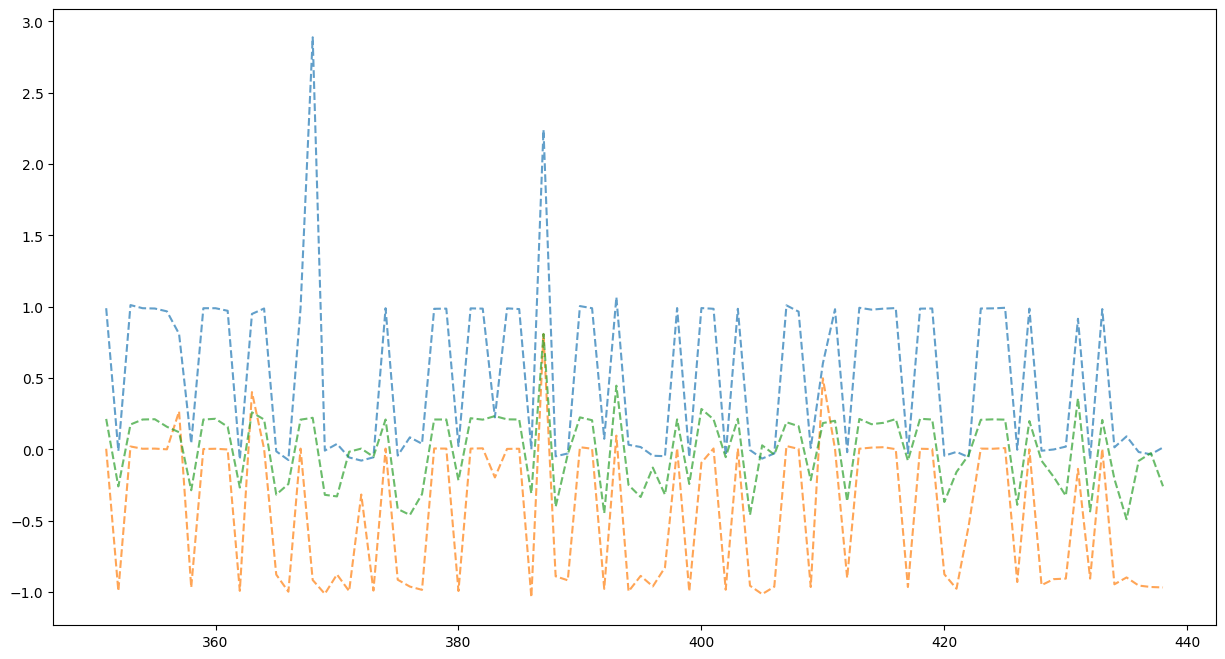

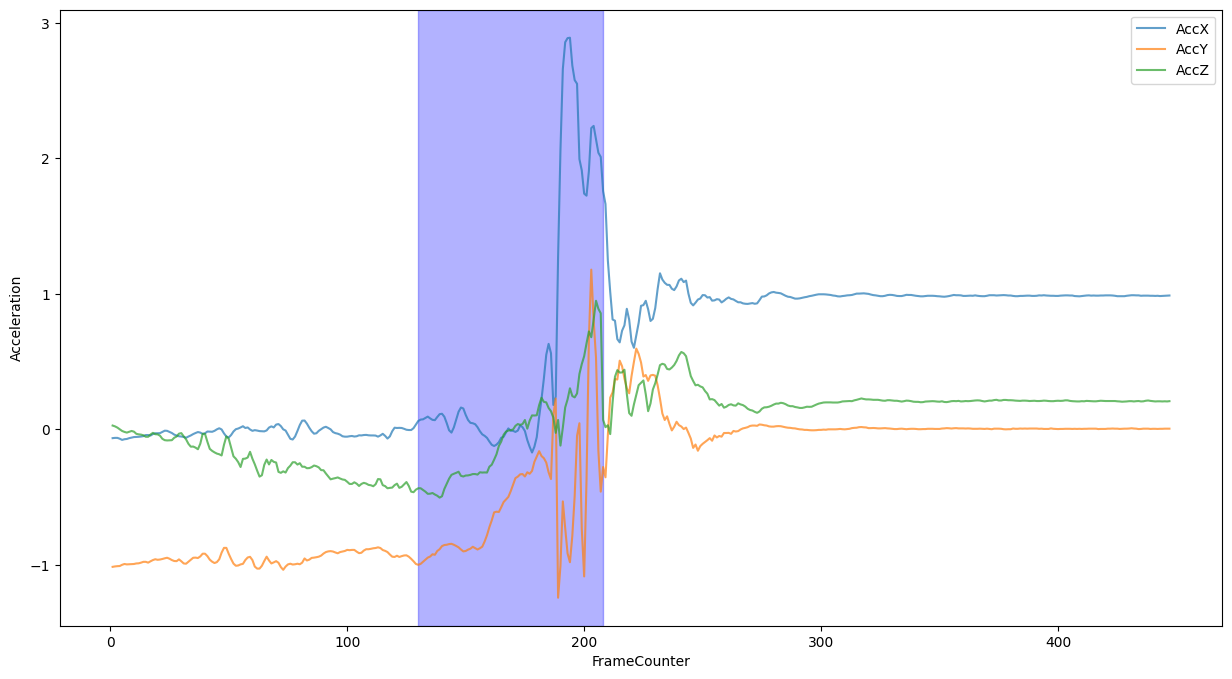

In [43]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Specify column data types
dtype = {'FALL': int}  # Adjust data types as needed

# Specify columns to exclude
exclude_columns = ['TimeStamp(s)', 'GyrX', 'GyrY', 'GyrZ', 'EulerX', 'EulerY', 'EulerZ', 'Description']  # Add the columns you want to exclude here

# Set the sampling percentage (0.1% in this case)
sampling_percentage = 1.0

# Load the specific file 'S06T01R01.csv'
merged_df = pd.read_csv("sensor_data/MODIFIEDSENSOR/S06T22R01.csv", dtype=dtype, usecols=lambda col: col not in exclude_columns)

# Assuming 'FALL' column is the target variable
# Separate features (X) and target variable (y)
X = merged_df.drop(columns=['FALL'])
y = merged_df['FALL']

# Apply windowing
window_size = 10  # Experiment with different window sizes

# Create windows for training data
X_train_windows = []
y_train_windows = []

for i in range(len(X) - window_size + 1):
    window = X.iloc[i: i + window_size]
    label = y.iloc[i + window_size - 1]  # Assuming y is a pandas Series

    X_train_windows.append(window.values)  # Convert window to a numpy array
    y_train_windows.append(label)

X_train_windows = np.array(X_train_windows)
y_train_windows = np.array(y_train_windows)

# Convert y_train_windows to 2D array
y_train_windows = y_train_windows.reshape(-1, 1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_windows, y_train_windows, test_size=0.2, random_state=42)

# Exclude non-numeric columns before scaling
numeric_columns = X.select_dtypes(include=np.number).columns
X_train_numeric = X_train[:, :, X.columns.isin(numeric_columns)]
X_test_numeric = X_test[:, :, X.columns.isin(numeric_columns)]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric.reshape(-1, X_train_numeric.shape[-1])).reshape(X_train_numeric.shape)
X_test_scaled = scaler.transform(X_test_numeric.reshape(-1, X_test_numeric.shape[-1])).reshape(X_test_numeric.shape)

# Reshape data for LSTM input (samples, timesteps, features)
X_train_reshaped = X_train_scaled
X_test_reshaped = X_test_scaled

# Build LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True, dropout=0.5),
    LSTM(16, return_sequences=True, dropout=0.5),
    Dense(1, activation='sigmoid')  # Using 'sigmoid' for binary classification
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

# Train model
history = model.fit(X_train_reshaped, y_train, epochs=4, batch_size=256, validation_split=0.2)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {test_acc}')

# Predict on the test set
y_pred = model.predict(X_test_reshaped)

# Choose a representation for predictions (e.g., mean or max over the window)
y_pred_mean = np.mean(y_pred, axis=1)

# Plot AccX, AccY, AccZ, and mark fall regions on the same graph
fig, ax = plt.subplots(figsize=(15, 8))

# Plot AccX, AccY, AccZ
for i, acc_label in enumerate(['AccX', 'AccY', 'AccZ']):
    ax.plot(merged_df['FrameCounter'].iloc[len(X_train):len(X_train) + len(X_test)],
            X_test[:, 0, X.columns.get_loc(acc_label)],
            label=f'{acc_label}', linestyle='dashed', alpha=0.7)

# Specify column data types
dtype = {'FALL': int}  # Adjust data types as needed

# Specify columns to exclude
exclude_columns = ['TimeStamp(s)', 'GyrX', 'GyrY', 'GyrZ', 'EulerX', 'EulerY', 'EulerZ', 'Description']  # Add the columns you want to exclude here

# Set the sampling percentage (0.1% in this case)
sampling_percentage = 1.0

# Load the specific file 'S06T01R01.csv'
merged_df = pd.read_csv("sensor_data/MODIFIEDSENSOR/S06T22R01.csv", dtype=dtype, usecols=lambda col: col not in exclude_columns)

# Find indices of the first and last occurrences of 1 in the 'FALL' column
first_fall_index = merged_df.index[merged_df['FALL'] == 1].min()
last_fall_index = merged_df.index[merged_df['FALL'] == 1].max()

# Plot AccX, AccY, AccZ, and mark fall region on the same graph
fig, ax = plt.subplots(figsize=(15, 8))

# Plot AccX, AccY, AccZ
for acc_label in ['AccX', 'AccY', 'AccZ']:
    ax.plot(merged_df['FrameCounter'], merged_df[acc_label], label=f'{acc_label}', linestyle='solid', alpha=0.7)

# Mark fall region
ax.axvspan(merged_df['FrameCounter'].iloc[first_fall_index],
           merged_df['FrameCounter'].iloc[last_fall_index],
           color='blue', alpha=0.3)

plt.xlabel('FrameCounter')
plt.ylabel('Acceleration')
plt.legend()
plt.show()


Epoch 1/4
2/2 [==============================] - 5s 883ms/step - loss: 0.7035 - accuracy: 0.3846 - val_loss: 0.6924 - val_accuracy: 0.3586
Epoch 2/4
2/2 [==============================] - 0s 39ms/step - loss: 0.6843 - accuracy: 0.5132 - val_loss: 0.6728 - val_accuracy: 0.5471
Epoch 3/4
2/2 [==============================] - 0s 38ms/step - loss: 0.6673 - accuracy: 0.6261 - val_loss: 0.6536 - val_accuracy: 0.6529
Epoch 4/4
3/3 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6875
Test Accuracy: 0.6875
3/3 [==============================] - 1s 3ms/step


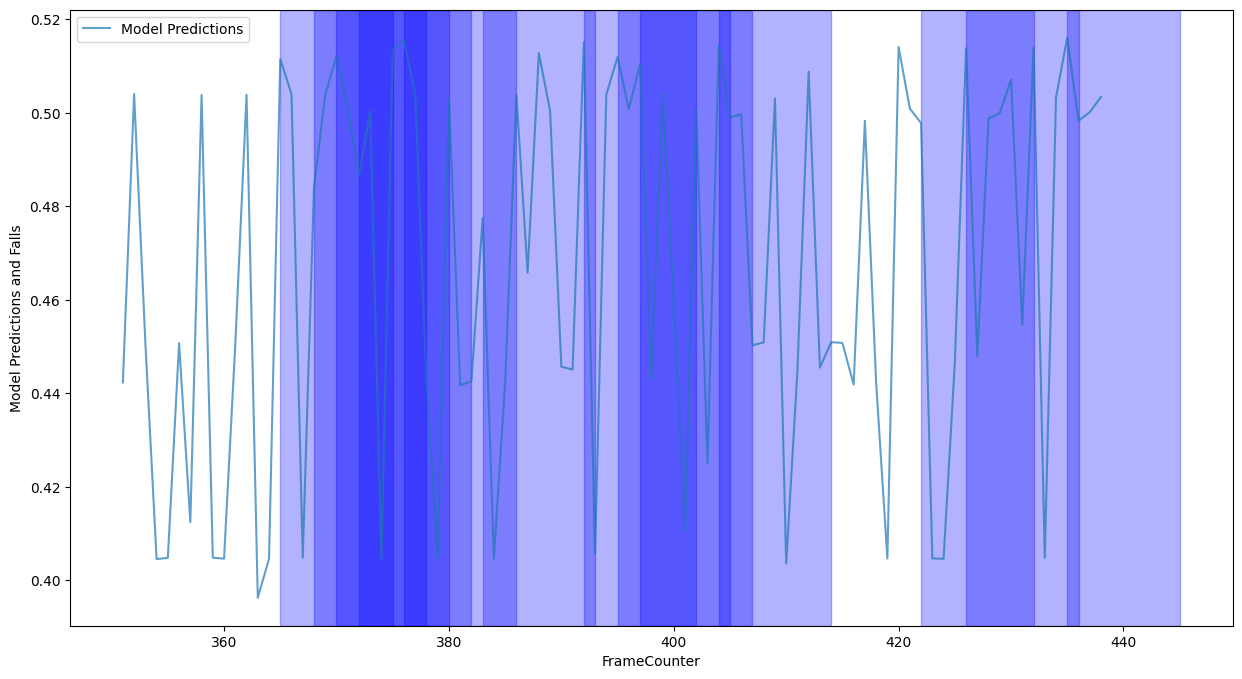

In [44]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the specific file 'S06T01R01.csv'
merged_df = pd.read_csv("sensor_data/MODIFIEDSENSOR/S06T22R01.csv")

# Assuming 'FALL' column is the target variable
# Separate features (X) and target variable (y)
X = merged_df.drop(columns=['FALL'])
y = merged_df['FALL']

# Apply windowing
window_size = 10  # Experiment with different window sizes

# Create windows for training data
X_train_windows = []
y_train_windows = []

for i in range(len(X) - window_size + 1):
    window = X.iloc[i: i + window_size]
    label = y.iloc[i + window_size - 1]  # Assuming y is a pandas Series

    X_train_windows.append(window.values)  # Convert window to a numpy array
    y_train_windows.append(label)

X_train_windows = np.array(X_train_windows)
y_train_windows = np.array(y_train_windows)

# Convert y_train_windows to 2D array
y_train_windows = y_train_windows.reshape(-1, 1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_windows, y_train_windows, test_size=0.2, random_state=42)

# Exclude non-numeric columns before scaling
numeric_columns = X.select_dtypes(include=np.number).columns
X_train_numeric = X_train[:, :, X.columns.isin(numeric_columns)]
X_test_numeric = X_test[:, :, X.columns.isin(numeric_columns)]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric.reshape(-1, X_train_numeric.shape[-1])).reshape(X_train_numeric.shape)
X_test_scaled = scaler.transform(X_test_numeric.reshape(-1, X_test_numeric.shape[-1])).reshape(X_test_numeric.shape)

# Reshape data for LSTM input (samples, timesteps, features)
X_train_reshaped = X_train_scaled
X_test_reshaped = X_test_scaled

# Build LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True, dropout=0.5),
    LSTM(16, return_sequences=True, dropout=0.5),
    Dense(1, activation='sigmoid')  # Using 'sigmoid' for binary classification
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

# Train model
history = model.fit(X_train_reshaped, y_train, epochs=4, batch_size=256, validation_split=0.2)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {test_acc}')

# Predict on the test set
y_pred = model.predict(X_test_reshaped)

# Choose a representation for predictions (e.g., mean or max over the window)
y_pred_mean = np.mean(y_pred, axis=1)

# Plot the model's predictions and actual falls on the same graph
fig, ax = plt.subplots(figsize=(15, 8))

# Plot model's predictions
ax.plot(merged_df['FrameCounter'].iloc[len(X_train):len(X_train) + len(X_test)], y_pred_mean, label='Model Predictions', linestyle='solid', alpha=0.7)

# Mark actual fall regions
fall_regions = np.where(y_test == 1)[0]
for region in fall_regions:
    ax.axvspan(merged_df['FrameCounter'].iloc[len(X_train) + region],
               merged_df['FrameCounter'].iloc[len(X_train) + region + window_size],
               color='blue', alpha=0.3)

plt.xlabel('FrameCounter')
plt.ylabel('Model Predictions and Falls')
plt.legend()
plt.show()


The correlation matrix below highlights the significance of AccY, revealing the highest correlation coefficient with the Fall label. This finding underlines the direct relationship between AccY measurements and the occurrence of falls.

## Correlation Matrix

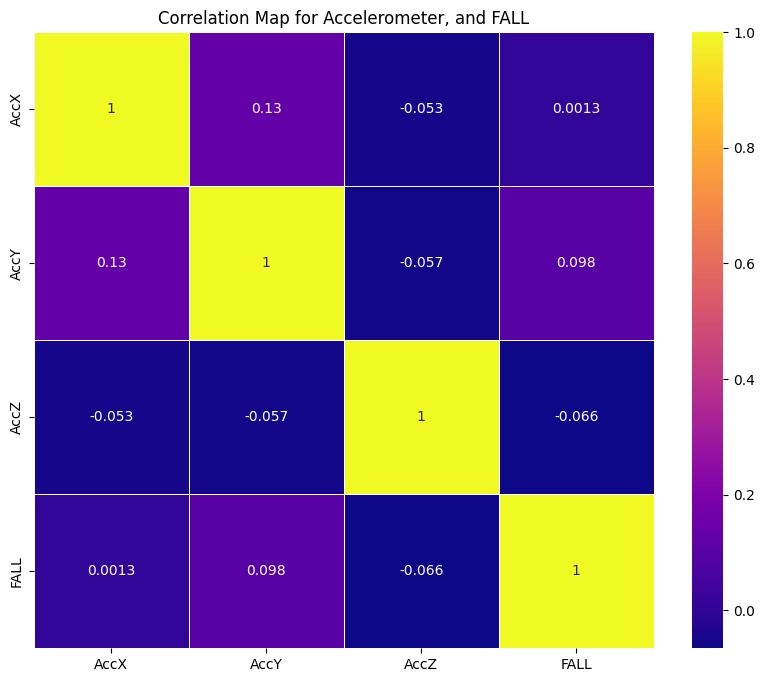

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the dataset from the CSV file
file_path = "sensor_data/MODIFIEDSENSOR/merged_data_filtered.csv"  # Replace with the actual path to your file
df = pd.read_csv(file_path)

# Select relevant columns for correlation analysis
selected_columns = ['AccX', 'AccY', 'AccZ', 'FALL']
selected_data = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='plasma', linewidths=.5)
plt.title('Correlation Map for Accelerometer, and FALL')
plt.show()

The box plot illustrates that AccY exhibits the largest statistical deviation among measurements. This variability in AccY values can serve as a distinguishing factor in capturing the nuanced patterns associated with falls.

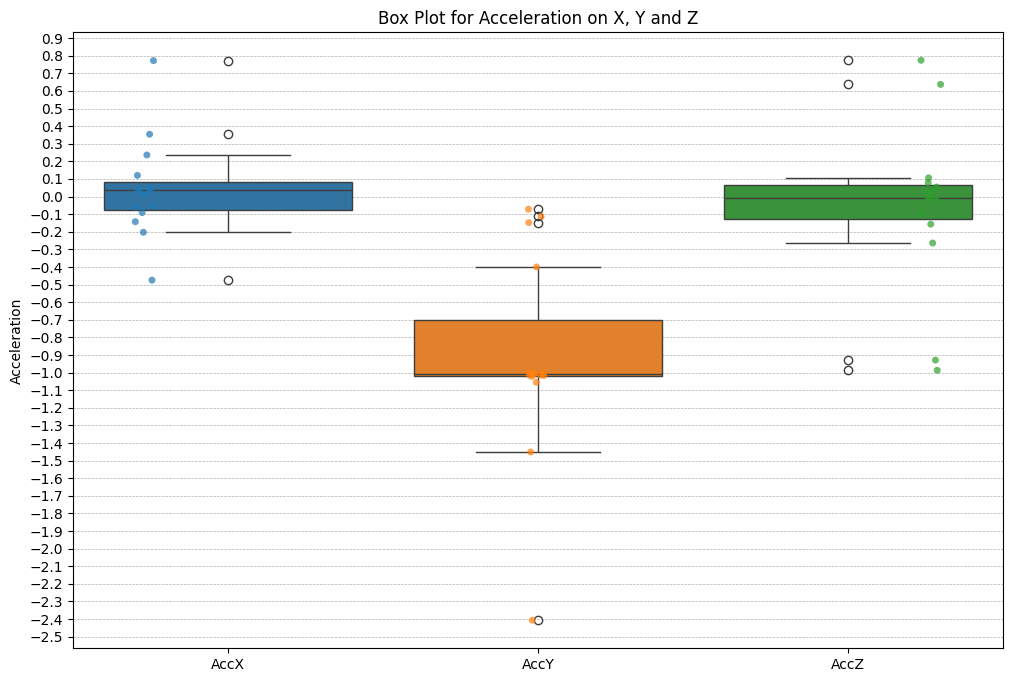

In [97]:
# Create box plots for accx, accy, and accz
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Feature', y='Value', hue='Feature',
                 data=pd.melt(df_sample[['AccX', 'AccY', 'AccZ']].head(15), id_vars=None, var_name='Feature', value_name='Value'))

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set y-axis ticks in 0.1 increments
ax.set_yticks([i/10 for i in range(int(ax.get_ylim()[0]*10), int(ax.get_ylim()[1]*10)+1)])

# Overlay individual data points with stripplot
sns.stripplot(x='Feature', y='Value', hue='Feature',
              data=pd.melt(df_sample[['AccX', 'AccY', 'AccZ']].head(15), id_vars=None, var_name='Feature', value_name='Value'),
              dodge=True, jitter=True, marker='o', alpha=0.7)

# Annotate outlier points with their values
outliers = []
for artist in ax.artists:
    # Iterate over each box
    for path in artist.get_paths():
        # Iterate over each outlier point
        for point in path.vertices:
            outliers.append(point[1])

for i, value in enumerate(outliers):
    ax.text(i % 3, value, f'{value:.2f}', ha='center', va='bottom', color='red', fontsize=8)

plt.title('Box Plot for Acceleration on X, Y and Z')
plt.xlabel('')
plt.ylabel('Acceleration')
plt.show()

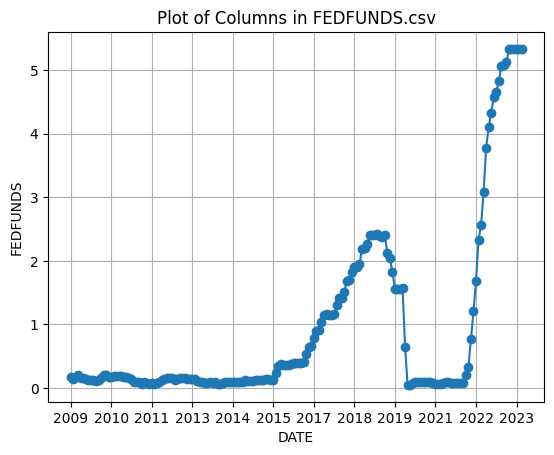

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('FEDFUNDS.csv')

# Assuming the columns are named 'DATE' and 'FEDFUNDS', replace these with your actual column names
column1_name = 'DATE'
column2_name = 'FEDFUNDS'

# Specify the starting row (e.g., 656)
start_row = 656

# Extract the year from the 'DATE' column
data['Year'] = pd.to_datetime(data[column1_name]).dt.year

# Plot the data starting from the specified row
plt.plot(data.iloc[start_row:][column1_name], data.iloc[start_row:][column2_name], marker='o', linestyle='-')

# Set x-axis ticks and labels for every year
years = data.iloc[start_row:]['Year'].unique()
plt.xticks(data.iloc[start_row:][column1_name][::len(years)], data.iloc[start_row:]['Year'][::len(years)])

plt.title('Plot of Columns in FEDFUNDS.csv')
plt.xlabel(column1_name)
plt.ylabel(column2_name)
plt.grid(True)
plt.show()


In [50]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the symbol for Bitcoin (BTC-USD)
symbol = "BTC-USD"

# Get historical data
data = yf.download(symbol, start="2010-01-01", end="2024-01-01")

# Extract prices for January 1st of each year
january_prices = data[data.index.month == 1][['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Plot the prices
plt.figure(figsize=(10, 6))
plt.plot(january_prices.index, january_prices['Close'], marker='o', linestyle='-', label='Bitcoin Close Price')
plt.title('Bitcoin Prices on January 1st Each Year')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'yfinance'

Examining the feature map, AccY ranks as the second most important feature out of the three acceleration components (AccX, AccY, AccZ). This positioning reaffirms the relevance of AccY in contributing significantly to the model's understanding of fall patterns.

/var/folders/fm/428pk89j30qgp_sg0g_g4gv40000gn/T/ipykernel_23956/1888350251.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




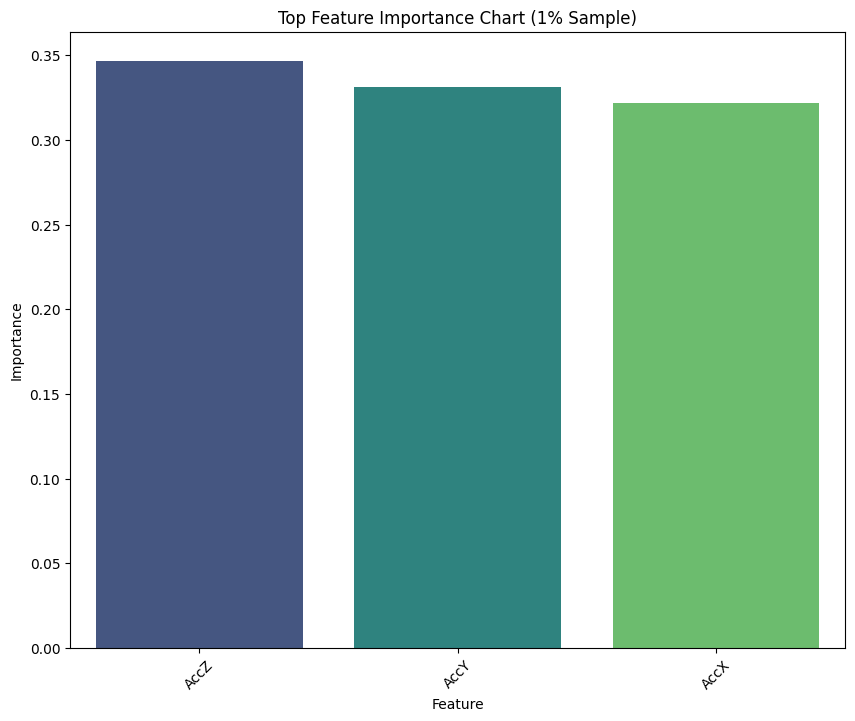

In [98]:



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Read the dataset from the CSV file
file_path = "sensor_data/MODIFIEDSENSOR/merged_data_filtered.csv"  # Replace with the actual path to your file
df = pd.read_csv(file_path)

# Drop 'FrameCounter' column
df = df.drop(columns=['FrameCounter'])

# Use a subsample of the data to speed up training
sample_size = 0.01  # Set the desired subsample size, 1% in this case
df_sample = df.sample(frac=sample_size, random_state=42)
X = df_sample.drop(columns=['FALL'])
y = df_sample['FALL']

# Initialize a Random Forest classifier with 4 cores
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=4)  # Adjust the number of estimators

# Fit the model
rf_classifier.fit(X, y)

# Get feature importances and standard deviations
feature_importances = rf_classifier.feature_importances_
std_importances = X.std(axis=0)  # Standard deviation for each feature

# Create a DataFrame for feature importances and standard deviations
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances,
    'StdDev': std_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for top 15 feature importances with vertical bars
plt.figure(figsize=(10, 8))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top Feature Importance Chart (1% Sample)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()



Drawing conclusions from the plots above, AccY could be a pivotal feature in identifying falls. The box plot illustrates that AccY exhibits the largest statistical deviation among measurements, and the correlation map shows it has the highest correlation with Falls. 

The discrepancy between the Random Forrest Feature Importance chart and the other 2 methods of analysis could arise due to the distinct perspectives these provide. Random Forest prioritizes features based on their collective impact on predictive accuracy, while correlation analysis specifically examines the linear relationship between individual features and the target variable. 

## Results

The decision to employ Long Short-Term Memory (LSTM) models for human fall identification was judicious, presenting substantial advantages for the task at hand. LSTMs excel in capturing sequential dependencies within time-series data, making them well-suited for analyzing acceleration measurements over time. Their capacity to selectively retain or discard information over extended sequences seamlessly aligns with the nuanced patterns inherent in human movements, particularly during falls.

During the optimization process, various parameters were tested, encompassing epochs, dropouts, and batch size. Opting for 4 epochs and a batch size of 256 served a dual purpose of enhancing model efficiency and expediting computations. Introducing a dropout of 0.5 didn't accelerate the model but did enhance its accuracy by 2%, ensuring a faster and more reliable fall detection system that meets real-world constraints demanding swift responses.

The dataset underwent refinement, retaining only essential features—Acceleration measurements and a binary Fall label (1 for fall and 0 for no fall). Merging sensor and label data into a unified file streamlined data processing.

Exploration of different batch sizes and learning rates revealed minimal impact on the model's speed or accuracy. Additionally, escalating the number of epochs resulted in prolonged computation times. At 4 epochs, processing time was around 8 seconds, increasing to 9.6 seconds at 8 epochs and 12 seconds at 16 epochs. Intriguingly, accuracy improvements with more epochs were marginal, approximately 0.001 percentage points. This underscores the need to strike a balance between computational efficiency and incremental gains in accuracy, especially in real-time fall detection scenarios where rapid processing is paramount.

The largest factor for trade-offs between computational speed and accuracy was when varying sample sizes. For instance, a sampling percentage of 10% took 2 minutes, while 100% required 22 minutes. The chart below illustrates marginal accuracy benefits with increasing sampling percentages, accompanied by exceedingly large computation times. 



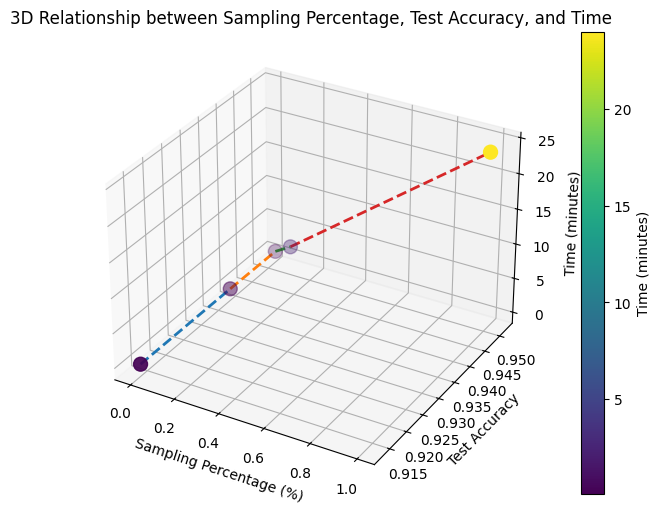

In [94]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data
sampling_percentages = [0.0001, 0.001, 0.01, 0.1, 1]
test_accuracies = [0.9132851958274841, 0.9384549260139465, 0.9515590667724609, 0.950480580329895, 0.9501]
times_minutes = [0.106, 0.125, 0.366, 2.33, 24]  # Time in minutes

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting
scatter = ax.scatter(sampling_percentages, test_accuracies, times_minutes, c=times_minutes, cmap='viridis', s=100)

# Connect consecutive points with lines
for i in range(len(sampling_percentages) - 1):
    ax.plot([sampling_percentages[i], sampling_percentages[i + 1]], 
            [test_accuracies[i], test_accuracies[i + 1]], 
            [times_minutes[i], times_minutes[i + 1]], 
            linestyle='--', linewidth=2)

# Add colorbar to indicate time
cbar = plt.colorbar(scatter)
cbar.set_label('Time (minutes)')

ax.set_xlabel('Sampling Percentage (%)')
ax.set_ylabel('Test Accuracy')
ax.set_zlabel('Time (minutes)')
ax.set_title('3D Relationship between Sampling Percentage, Test Accuracy, and Time')

plt.show()
